 ## Import data and build dataloader

In [1]:
#import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch, os, collections
import pandas as pd
import pickle5 as pickle
from tqdm import tqdm

class ProtEmbDataset(Dataset):
    """Protein emb dataset."""
    def __init__(self, model_name, transform=None):
        """
        Args:
            root_dir (string): Directory with all the datapoints.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/%s_batch128/'%(model_name)
        self.filenames = os.listdir(self.data_path)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        file_ = self.filenames[idx]
        with open(self.data_path+file_, 'rb') as handle:
            datapoint = pickle.load(handle)
        embs = datapoint['embs']
        labels = datapoint['labels']
        return embs, labels

# # Load pickle file
# with open('data/reduced.pkl', 'rb') as f:
#     data = pickle.load(f)

model_name = 'esm1_t6_43M_UR50S'
protein_dataset = ProtEmbDataset(model_name, model_name)

/home/dell4/miniconda3/envs/ion/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np

# Create a validation and training set
samples_count = len(protein_dataset)
all_samples_indexes = list(range(samples_count))
np.random.shuffle(all_samples_indexes)

val_ratio = 0.2
val_end = int(samples_count * val_ratio)
val_indexes = all_samples_indexes[0:val_end]
train_indexes = all_samples_indexes[val_end:]
assert len(val_indexes) + len(train_indexes) == samples_count , 'the split is not valid' 

sampler_train = data.SubsetRandomSampler(train_indexes)
sampler_val = data.SubsetRandomSampler(val_indexes)

dataloader_train = DataLoader(protein_dataset, batch_size=1, sampler = sampler_train, num_workers=4)
dataloader_val = DataLoader(protein_dataset, batch_size=1, sampler = sampler_val, num_workers=4)
# dataloader_test = DataLoader(protein_dataset, batch_size=1,
#                         shuffle=True, num_workers=4)

len(dataloader_train), len(dataloader_val)

(176, 43)

In [5]:
dataloader_train.dataset[0][1].keys()

dict_keys(['CA', 'CO', 'CU', 'FE2', 'FE', 'MG', 'MN', 'PO4', 'SO4', 'ZN', 'null'])

## Initialize model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Self_Attention(nn.Module):
    def __init__(self, num_hidden, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.attention_head_size = int(num_hidden / num_heads)
        self.all_head_size = self.num_heads * self.attention_head_size

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        #print(x.shape)
        return x.permute(0, 2, 1)

    def forward(self, q, k, v, mask=None):
        q = self.transpose_for_scores(q) # [bsz, heads, protein_len, hid]
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attention_scores = torch.matmul(q, k.transpose(-1, -2))

        if mask is not None:
            attention_mask = (1.0 - mask) * -10000
            attention_scores = attention_scores + attention_mask.unsqueeze(1).unsqueeze(1)

        attention_scores = nn.Softmax(dim=-1)(attention_scores)

        outputs = torch.matmul(attention_scores, v)

        outputs = outputs.permute(0, 2, 1).contiguous()
        new_output_shape = outputs.size()[:-2] + (self.all_head_size,)
        outputs = outputs.view(*new_output_shape)
        return outputs


class PositionWiseFeedForward(nn.Module):
    def __init__(self, num_hidden, num_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.W_in = nn.Linear(num_hidden, num_ff, bias=True)
        self.W_out = nn.Linear(num_ff, num_hidden, bias=True)

    def forward(self, h_V):
        h = F.leaky_relu(self.W_in(h_V))
        h = self.W_out(h)
        return h

class TransformerLayer(nn.Module):
    def __init__(self, num_hidden = 64, num_heads = 4, dropout = 0.2):
        super(TransformerLayer, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.ModuleList([nn.LayerNorm(num_hidden, eps=1e-6) for _ in range(2)])

        self.attention = Self_Attention(num_hidden, num_heads)
        self.dense = PositionWiseFeedForward(num_hidden, num_hidden * 4)

    def forward(self, h_V, mask=None):
        # Self-attention
        dh = self.attention(h_V, h_V, h_V, mask)
        h_V = self.norm[0](h_V + self.dropout(dh))

        # Position-wise feedforward
        dh = self.dense(h_V)
        h_V = self.norm[1](h_V + self.dropout(dh))

        if mask is not None:
            mask = mask.unsqueeze(-1)
            h_V = mask * h_V
        return h_V


class IonicProtein(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, num_encoder_layers=2, num_heads=4, augment_eps=0.05, dropout=0.2):
        super(IonicProtein, self).__init__()

        # Hyperparameters
        self.augment_eps = augment_eps

        # Embedding layers
        self.input_block = nn.Sequential(
                                         nn.LayerNorm(feature_dim, eps=1e-6)
                                        ,nn.Linear(feature_dim, hidden_dim)
                                        ,nn.LeakyReLU()
                                        )

        self.hidden_block = nn.Sequential(
                                          nn.LayerNorm(hidden_dim, eps=1e-6)
                                         ,nn.Dropout(dropout)
                                         ,nn.Linear(hidden_dim, hidden_dim)
                                         ,nn.LeakyReLU()
                                         ,nn.LayerNorm(hidden_dim, eps=1e-6)
                                         )

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerLayer(hidden_dim, num_heads, dropout)
            for _ in range(num_encoder_layers)
        ])

        # ion-specific layers
        # dict_keys(['CA', 'CO', 'CU', 'FE2', 'FE', 'MG', 'MN', 'PO4', 'SO4', 'ZN', 'null'])
        self.FC_CA_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_CA_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_CO_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_CO_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_CU_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_CU_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_FE2_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_FE2_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_FE_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_FE_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_MG_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_MG_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_MN_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_MN_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_PO4_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_PO4_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_SO4_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_SO4_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_ZN_1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_ZN_2 = nn.Linear(hidden_dim, 1, bias=True)
        self.FC_null1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.FC_null2 = nn.Linear(hidden_dim, 1, bias=True)

        # Initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def forward(self, protein_feat, mask):
        # Data augmentation
        if self.training and self.augment_eps > 0:
            protein_feat = protein_feat + self.augment_eps * torch.randn_like(protein_feat)

        h_V = self.input_block(protein_feat)
        h_V = self.hidden_block(h_V)

        for layer in self.encoder_layers:
            h_V = layer(h_V, mask)
        
        #print(h_V)
        # dict_keys(['CA', 'CO', 'CU', 'FE2', 'FE', 'MG', 'MN', 'PO4', 'SO4', 'ZN', 'null'])
        logits_CA = self.FC_CA_2(F.leaky_relu(self.FC_CA_1(h_V))).squeeze(-1) # [batch_size, maxlen]
        logits_CO = self.FC_CO_2(F.leaky_relu(self.FC_CO_1(h_V))).squeeze(-1)
        logits_CU = self.FC_CU_2(F.leaky_relu(self.FC_CU_1(h_V))).squeeze(-1)
        logits_FE2 = self.FC_FE2_2(F.leaky_relu(self.FC_FE2_1(h_V))).squeeze(-1)
        logits_FE = self.FC_FE_2(F.leaky_relu(self.FC_FE_1(h_V))).squeeze(-1) # [batch_size, maxlen]
        logits_MG = self.FC_MG_2(F.leaky_relu(self.FC_MG_1(h_V))).squeeze(-1)
        logits_MN = self.FC_MN_2(F.leaky_relu(self.FC_MN_1(h_V))).squeeze(-1)
        logits_PO4 = self.FC_PO4_2(F.leaky_relu(self.FC_PO4_1(h_V))).squeeze(-1)
        logits_SO4 = self.FC_SO4_2(F.leaky_relu(self.FC_SO4_1(h_V))).squeeze(-1) # [batch_size, maxlen]
        logits_ZN = self.FC_ZN_2(F.leaky_relu(self.FC_ZN_1(h_V))).squeeze(-1)
        logits_null = self.FC_null2(F.leaky_relu(self.FC_null1(h_V))).squeeze(-1)

        #print(logits_ZN.shape, logits_CA.shape, logits_MG.shape, logits_MN.shape)
        
        #logits = torch.cat((logits_ZN, logits_CA, logits_MG, logits_MN), 1)
        return logits_CA, logits_CO, logits_CU, logits_FE2, logits_FE, logits_MG, logits_MN, logits_PO4, logits_SO4, logits_ZN, logits_null

In [10]:
# for i, (embs, labels) in enumerate(dataloader_train):
#     #print(i, embs, labels)
#     embs = torch.squeeze(embs)
#     #fields = ['ZN', 'CA', 'MG', 'MN', 'null']
#     fields = list(dataloader_train.dataset[0][1].keys())
#     labels = [torch.tensor(labels[key], dtype=float) for key in fields]
#     #(lbl_ion1, lbl_ion2, lbl_ion3, lbl_ion4, lbl_null) = labels
#     break

In [23]:
from sklearn.metrics import f1_score

def train_val(model, dataloader, optimizer, criterion_1, is_training, device, topk, interval, e):
    batch_cnt = len(dataloader)
    fields = list(dataloader.dataset[0][1].keys())
    #fields = ['ZN', 'CA', 'MG', 'MN', 'null']
    #accuracies = [0.0]*len(fields)
    f1_scores = [0.0]*len(fields)
    status = 'training' if is_training else 'validation'

    with torch.set_grad_enabled(is_training):
        model.train() if is_training else model.eval()
        with tqdm(dataloader, unit="batch") as tepoch:
            loss_, f1_score_mc_ = [], []
            for embs, labels in tepoch:
                tepoch.set_description(f"Epoch {e}")
                embs = torch.squeeze(embs).to(device)
                #embs = torch.unsqueeze(embs, (2)).to(device)
                #print(fields)
                labels_ = [torch.squeeze(torch.tensor(labels[key], dtype=float)).to(device) for key in fields]
                (lbl_ion1, lbl_ion2, lbl_ion3, lbl_ion4, lbl_ion5, lbl_ion6, lbl_ion7, lbl_ion8, lbl_ion9, lbl_ion10, lbl_null) = labels_

                #print(embs.shape)
                predictions = model(embs, mask=None)
                (prd_ion1, prd_ion2, prd_ion3, prd_ion4, prd_ion5, prd_ion6, prd_ion7, prd_ion8, prd_ion9, prd_ion10, prd_null) = predictions

                def cal_loss(prd, lbl):
                    return criterion_1(torch.squeeze(prd), lbl)

                loss_final = 0
                for prds, lbls in zip(predictions, labels_):
                    loss_final+=cal_loss(prds, lbls)

                m = nn.Sigmoid()

                # f1_scores[0] = f1_score(lbl_ion1.cpu().data.numpy(), 
                #                 torch.round(m(prd_ion1)).cpu().data.numpy(), average='macro')
                # f1_scores[1] = f1_score(lbl_ion2.cpu().data.numpy(),
                #                 torch.round(m(prd_ion2)).cpu().data.numpy(), average='macro')
                # f1_scores[2] = f1_score(lbl_ion3.cpu().data.numpy(),
                #                 torch.round(m(prd_ion3)).cpu().data.numpy(), average='macro')
                # f1_scores[3] = f1_score(lbl_ion4.cpu().data.numpy(), 
                #                 torch.round(m(prd_ion4)).cpu().data.numpy(), average='macro')
                # f1_scores[4] = f1_score(lbl_null.cpu().data.numpy(), 
                #                 torch.round(m(prd_null)).cpu().data.numpy(), average='macro')

                #print(torch.round(m(torch.stack(predictions))).cpu().data.numpy(), torch.stack(labels_).cpu().data.numpy())
                f1_score_mc = f1_score(torch.round(m(torch.stack(predictions))).cpu().data.numpy(),
                                        torch.stack(labels_).cpu().data.numpy(), average='micro')

                tepoch.set_postfix(loss=loss_final, f1_avg=f1_score_mc)

                #print(accuracies)

                if is_training:
                    optimizer.zero_grad()
                    loss_final.backward()
                    optimizer.step()

                loss_.append(loss_final)
                f1_score_mc_.append(f1_score_mc)
            
                # if i%interval==0:
                #     # accs = [acc/batch_cnt for acc in accuracies]
                #     accs = [acc for acc in f1_scores]
                #     print(f'[{status}] iter: {i} loss: {loss_final.item():6f}')
                #     print (' ,'.join(list(f'{f}: {x:.4f}' for f, x in zip(fields, accs))))
                #     print('F1score MC:', f1_score_mc)
    return loss_, f1_score_mc_
            
from tqdm import trange

def train_loop(model, epochs, dataloader_train, dataloader_val,
               optimizer, lr_scheduler, criterion_1, interval):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    net_loss_train, net_f1_train, net_loss_test, net_f1_test = [], [], [], []

    for e in range(epochs):
        with tqdm(dataloader_train, unit="batch") as tepoch:
            lrs = [f'{lr:.6f}' for lr in lr_scheduler.get_lr()]
            #print(f'epoch {e} : lrs : {" ".join(lrs)}')
            loss_, f1_score_mc_ = train_val(model, dataloader_train, optimizer, criterion_1, True, device, 1, interval, e)
            net_loss_train.append((sum(loss_)/len(dataloader_train)).item())   # Save loss
            net_f1_train.append((sum(f1_score_mc_)/len(dataloader_train)).item()) # Save f1

            loss_, f1_score_mc_ = train_val(model, dataloader_val, optimizer, criterion_1, False, device, 1, interval, e)
            net_loss_test.append((sum(loss_)/len(dataloader_val)).item())  # Save loss
            net_f1_test.append((sum(f1_score_mc_)/len(dataloader_val)).item()) # Save f1
            lr_scheduler.step()

    return  net_loss_train, net_f1_train, net_loss_test, net_f1_test
        

In [8]:
len(dataloader_train)

176

In [24]:
import torch

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# #device = 'cpu'
#model = IonNet(768).to(device=device)
model = IonicProtein(dataloader_train.dataset[0][0].shape[1]).to(device)
criterion_1 = nn.BCEWithLogitsLoss()
#criterion_2 = nn.MultiLabelSoftMarginLoss()
#criterion_1 = nn.MSELoss()

epochs = 10
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

lrsched = torch.optim.lr_scheduler.StepLR(optimizer, 10)

net_loss_train, net_f1_train, net_loss_test, net_f1_test = train_loop(model, epochs, dataloader_train, dataloader_val, optimizer, lrsched, criterion_1, 100)

  0%|          | 0/176 [02:06<?, ?batch/s]


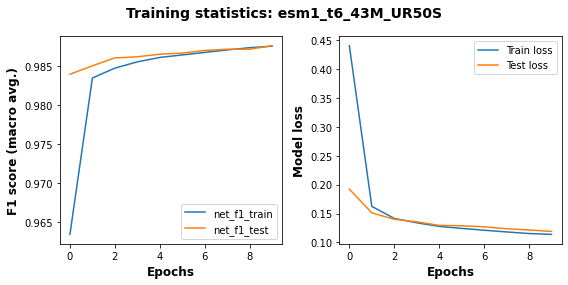

In [58]:
import matplotlib.pyplot as plt
# net_loss_train, net_f1_train, net_loss_test, net_f1_test
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[1].plot(range(len(net_loss_train)), net_loss_train, label='Train loss')
ax[1].plot(range(len(net_loss_test)), net_loss_test, label='Test loss')
ax[1].set_ylabel('Model loss', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax[1].legend()
ax[0].plot(range(len(net_f1_train)), net_f1_train, label='net_f1_train')
ax[0].plot(range(len(net_f1_test)), net_f1_test, label='net_f1_test')
ax[0].set_ylabel('F1 score (macro avg.)', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax[0].legend()
fig.suptitle('Training statistics: %s'%(model_name), fontsize=14, fontweight='bold')
plt.tight_layout()


In [60]:
training_stats = pd.DataFrame()
training_stats['net_loss_train'] = net_loss_train
training_stats['net_loss_test'] = net_loss_test
training_stats['net_f1_train'] = net_f1_train
training_stats['net_f1_test'] = net_f1_test

training_stats.to_csv('checkpoints/%s.csv'%(model_name))

In [16]:
#fields = list(dataloader.dataset[0][1].keys())
fields = ['ZN', 'CA', 'MG', 'MN', 'null']
accuracies = [0.0]*len(fields)
#status = 'training' if is_training else 'validation'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

m = nn.Sigmoid()

for i, (embs, labels) in tqdm(enumerate(dataloader_train)):
    embs = torch.squeeze(embs).to(device)
    #mbs = torch.unsqueeze(embs, (2)).to(device)
    #print(fields)
    labels = [torch.tensor(labels[key], dtype=float).to(device) for key in fields]
    (lbl_ion1, lbl_ion2, lbl_ion3, lbl_ion4, lbl_null) = labels
    preds = model(embs, mask=None)
    (prd_ion1, prd_ion2, prd_ion3, prd_ion4, prd_null) = preds
    
    #accuracies = [0.0]*len(fields)
    accuracies[0] = torch.mean((torch.round(m(prd_ion1)) == lbl_ion1).float())
    accuracies[1] = torch.mean((torch.round(m(prd_ion2)) == lbl_ion2).float())
    accuracies[2] = torch.mean((torch.round(m(prd_ion3)) == lbl_ion3).float())
    accuracies[3] = torch.mean((torch.round(m(prd_ion4)) == lbl_ion3).float())
    accuracies[4] = torch.mean((torch.round(m(prd_null)) == lbl_null).float())
    break

0it [00:05, ?it/s]


In [17]:
accuracies

[tensor(1., device='cuda:0'),
 tensor(0.9943, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0')]

In [50]:
logits_ZN, logits_CA, logits_MG, logits_MN = model(dataloader_train.dataset[0][0], mask=None)

torch.Size([223]) torch.Size([223]) torch.Size([223]) torch.Size([223])


In [57]:
logits_MN

tensor([-8.1187e-01, -3.2371e-01,  5.3390e-01,  6.4721e-01, -2.5269e-01,
        -2.6061e-01,  9.5369e-01,  1.1181e+00, -8.5976e-01, -3.5914e-01,
        -7.5647e-01,  1.2678e+00,  8.6327e-01, -3.0958e-01,  9.7458e-01,
         3.3607e-01,  2.1437e-01, -1.0128e+00,  8.9785e-01,  2.9640e-01,
        -6.1434e-01,  4.8736e-01, -1.6717e-01, -4.1570e-01,  4.4665e-01,
         3.0679e-01,  1.6282e+00,  1.8788e+00,  5.6163e-01, -1.5620e-03,
        -5.9097e-01,  6.3593e-01,  1.0147e-01,  7.2768e-01,  8.0659e-01,
         8.4326e-01,  7.9886e-01,  4.7904e-01,  1.1612e+00,  1.3238e+00,
         1.2278e+00, -8.7620e-01,  2.9172e-01,  1.1655e+00, -3.7997e-02,
        -3.3806e-01,  2.9960e-01,  8.3189e-01,  8.5580e-01,  4.8761e-01,
         1.2747e+00,  1.7801e-01, -1.3051e-02,  7.3867e-01,  8.4856e-01,
         1.3563e+00,  1.3695e+00,  1.2275e-01,  7.7704e-01,  2.1522e+00,
        -4.3794e-01,  5.5798e-01, -2.5288e-02,  8.7640e-01,  6.4032e-01,
         1.0137e+00,  1.0518e+00,  1.3257e+00,  7.1

In [20]:
dataloader_train.dataset[0][0].shape[1]

768

In [92]:
from torchviz import make_dot
make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

In [21]:
import pandas as pd
import collections
df = pd.read_csv('data/LigID_pdbchain_partition.csv')
print(collections.Counter(df['LigID']))
df.head()

Counter({'ZN': 7774, 'MG': 7494, 'CA': 6879, 'MN': 2049, 'FE': 1147, 'CU': 746, 'PO4': 690, 'SO4': 579, 'CO': 490, 'FE2': 462})


,LigID,pdb_chain,partitions
0,CA,1a0j_A,2
1,CA,1a0s_P,1
2,CA,1a25_A,1
3,CA,1a2q_A,2
4,CA,1a2t_A,4


In [32]:
# Load pickle file
import collections
import pickle5 as pickle
from tqdm import tqdm
with open('data/reduced.pkl', 'rb') as f:
    data_dict = pickle.load(f)

zeros, ones = 0, 0
print('Analyzing labels...')
for key in tqdm(data_dict.keys()):
    a = [int(x) for x in data_dict[key][1]]
    zeros=zeros+collections.Counter(a)[0]
    ones=ones+collections.Counter(a)[1]
    
# print('Zeros', zeros)
# print('Ones', ones)
# print('Ratio:', ones/zeros)

# print('\nAdding ion info to dict...')
# for key in tqdm(data_dict.keys()):
#     data_dict[key].append(df[df['pdb_chain']==key]['LigID'].item())
# #data_dict

Analyzing labels...


100%|██████████| 28310/28310 [00:01<00:00, 16233.22it/s]


Zeros 9072132
Ones 151172
Ratio: 0.01666333779094043

Adding ion info to dict...


100%|██████████| 28310/28310 [00:38<00:00, 744.44it/s]


In [33]:
aa = []
for key in tqdm(data_dict.keys()):
    aa.append(data_dict[key][2])
collections.Counter(aa)

100%|██████████| 28310/28310 [00:00<00:00, 2549835.64it/s]


Counter({'CA': 6879,
         'CO': 490,
         'CU': 746,
         'FE2': 462,
         'FE': 1147,
         'MG': 7494,
         'MN': 2049,
         'PO4': 690,
         'SO4': 579,
         'ZN': 7774})

In [82]:
ions = list(collections.Counter(df['LigID']).keys())
freq_dict = {k: [0,0] for k in ions}
zeros, ones = 0, 0
for key in tqdm(data_dict.keys()):
    a = [int(x) for x in data_dict[key][1]]
    zeros+=collections.Counter(a)[0]
    ones+=collections.Counter(a)[1]
    freq_dict[data_dict[key][2]][0]+=zeros
    freq_dict[data_dict[key][2]][1]+=ones
    
for ion in freq_dict.keys():
    zeros, ones = freq_dict[ion]
    print(ion, ': Zeros', zeros, ', Ones', ones, ', Ratio:', ones/zeros)

100%|██████████| 28310/28310 [00:01<00:00, 15915.94it/s]

CA : Zeros 7560207088 , Ones 181016360 , Ratio: 0.023943307093706425
CO : Zeros 1148794417 , Ones 26264356 , Ratio: 0.02286253798881406
CU : Zeros 1876301130 , Ones 42557806 , Ratio: 0.022681756845714846
FE2 : Zeros 1250032037 , Ones 27866360 , Ratio: 0.022292516651715222
FE : Zeros 3397572593 , Ones 73649002 , Ratio: 0.021676947286347503
MG : Zeros 33121903899 , Ones 606580722 , Ratio: 0.018313582572115173
MN : Zeros 12421163819 , Ones 205015462 , Ratio: 0.016505334362179384
PO4 : Zeros 4491340968 , Ones 74033171 , Ratio: 0.016483533877181242
SO4 : Zeros 3878365060 , Ones 64629398 , Ratio: 0.016664083189734592
ZN : Zeros 61457561704 , Ones 1024332347 , Ratio: 0.016667311858767263
